In [1]:
!pip install lxml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 20.9 MB/s eta 0:00:00a 0:00:01


In [8]:
from pmcfuncs import get_fulltext_from_xml, get_fulltext

In [42]:
import re

def clean_research_paper_text(text):
    """
    Cleans raw text extracted from a research paper for better embedding quality.
    """
    # Remove initial quote mark if present
    text = text.lstrip("'")

    # Remove unwanted characters/patterns (e.g., LaTeX remnants, non-standard symbols)
    text = re.sub(r'\\n', ' ', text)  # Replace escaped newlines with space
    text = re.sub(r'\\t', ' ', text)  # Replace escaped tabs with space
    text = re.sub(r'\\', '', text) # Remove backslashes that might be from LaTeX or escaped characters

    # Split the input text into individual lines
    lines = text.split('\n')
    cleaned_lines = []
    
    # Compile a regex pattern to detect table-like lines (with tabs, numbers, etc.)
    # - multiple numbers in parentheses, e.g., (9.45)
    # - min-max ranges like [42-78]
    # - repeated patterns of `\t` followed by data
    
    table_pattern = re.compile(r'\t.*?\(\d+\.?\d*\).*?\[.*?\]|\tN/A|\t\d+\s*\(.*?\)|\t[A-Za-z]+, [A-Za-z]+, [A-Za-z]+')

    for line in lines:
        # Check if the line seems like a table header or data row based on specific patterns
        if re.search(r'Variables\tMean \(sd\)', line) or \
           re.search(r'N \(baseline\)\t\d+\t\d+', line) or \
           re.search(table_pattern, line) or \
           re.search(r'Predictor\tcoef\tS\.E\tWald\tp', line) or \
           re.search(r'^\t\t.*?\t.*?\t.*?\t.*?\t.*?\t', line): # Lines with many tabs at the start for table-like data
            continue
        cleaned_lines.append(line)
        
    text = '\n'.join(cleaned_lines)

    # Remove reference IDs like "10.1007/s10072-023-07262-1" or "(Table 1)", "(Fig. 1S)" etc.
    text = re.sub(r'\b\d{2}\.\d{4}\/\S+?\b', '', text) # DOI patterns
    text = re.sub(r'\(Fig\. \d+S?\)|\[\d+\]|\(Table \d+S?\)|\(see Fig\. \d+S?\)', '', text) # Common citation/figure/table refs
    text = re.sub(r'\s[X,x]2\s=\s[\d.]+', '', text) # Chi2 patterns like X2 = 18.4565
    text = re.sub(r'\srho\s=\s\s?-\s?[\d.]+', '', text) # Spearman rho values
    text = re.sub(r'p\svalue\s=\s[\d.]+', '', text) # p-values
    text = re.sub(r'p\s=\s[\d.]+', '', text) # p-values simplified
    text = re.sub(r'\(N\s=\s\d+\)', '', text) # (N = 48) patterns
    text = re.sub(r'\(Pearson\'s Chi-squared test; Chi2 = [\d.]+, p value = [\d.]+\)', '', text)
    text = re.sub(r'\(Pearson\'s Chi-squared test, Chi2 = [\d.]+, p value = [\d.]+\)', '', text)
    text = re.sub(r'\(Pearson\'s Chi-squared test, X2 = [\d.]+, p value = [\d.]+\)', '', text)
    text = re.sub(r'\(X2 = [\d.]+, p = <[\d.]+\)', '', text) # p < 0.001
    text = re.sub(r'\(X2 = [\d.]+, p = [\d.]+\)', '', text) # generic (X2 = ..., p = ...)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip() # Replace multiple spaces/newlines with single space

    # Remove any trailing or leading quotes or apostrophes if they were a parsing artifact
    text = text.strip("'")

    return text


In [43]:
import os
import numpy as np

def load_embeddings(
    output_dir,
    embedding_filename="paper_embeddings.npy",
    paper_ids_filename="paper_ids.txt"
):
    """
    Loads saved paper embeddings and their corresponding paper IDs from a given directory.

    Args:
        output_dir (str): Directory containing the embeddings and ID files.
        embedding_filename (str): Filename of the .npy file storing embeddings.
        paper_ids_filename (str): Filename of the .txt file storing paper IDs.

    Returns:
        tuple:
            - embeddings (np.ndarray): Loaded embedding array.
            - paper_ids (List[str]): List of paper IDs.
    """
    embeddings_path = os.path.join(output_dir, embedding_filename)
    ids_path = os.path.join(output_dir, paper_ids_filename)

    try:
        embeddings = np.load(embeddings_path)
        with open(ids_path, 'r', encoding='utf-8') as f:
            paper_ids = [line.strip() for line in f]

        print(f"✅ Loaded {len(paper_ids)} embeddings from '{output_dir}' with shape: {embeddings.shape}")
        return embeddings, paper_ids

    except FileNotFoundError:
        print(f"❌ Error: One or both files not found in '{output_dir}'")
        print(f"Expected files: {embedding_filename}, {paper_ids_filename}")
        return None, None


In [44]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def perform_pca_and_plot(embeddings, n_components=50, variance_threshold=0.90 ):
    """
    Perform PCA on a set of embeddings and plot the cumulative explained variance.

    Args:
        embeddings (np.ndarray): 2D array of shape (num_samples, embedding_dim).
        n_components (int): Number of PCA components to compute.
        variance_threshold (float): Line threshold for cumulative variance plot.
        return_transformed (bool): If True, returns the PCA-transformed embeddings.

    Returns:
        explained_variance (np.ndarray): Explained variance ratio of each component.
    """
    print(f"Running PCA with {n_components} components on embeddings of shape {embeddings.shape}...")

    pca = PCA(n_components=n_components)
    transformed = pca.fit_transform(embeddings)
    explained_variance = pca.explained_variance_ratio_

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(explained_variance), marker='o')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA - Variance Explained')
    plt.grid(True)
    plt.axhline(y=variance_threshold, color='r', linestyle='--', label=f'{int(variance_threshold*100)}% Variance Threshold')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return explained_variance


In [45]:
import os
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
import gc
import re
from lxml import etree

def generate_paper_embeddings(
    df,
    model_name,
    max_sequence_length,
    overlap_tokens,
    batch_size,
    output_dir,
    embedding_filename="paper_embeddings.npy",
    paper_ids_filename="paper_ids.txt",
    base_xml_dir="/data/ftxmls"
):
    """
    Generate and save embeddings for research papers using a transformer model.

    Args:
        df (pd.DataFrame): DataFrame with 'id' and 'year' columns.
        model_name (str): Huggingface model name or path.
        max_sequence_length (int): Max token length per sequence.
        overlap_tokens (int): Overlap between chunks for long texts.
        batch_size (int): Number of papers to embed in a batch.
        output_dir (str): Directory to save embeddings and IDs.
        embedding_filename (str): Output filename for numpy embeddings.
        paper_ids_filename (str): Output filename for paper IDs.
        base_xml_dir (str): Path where the full text XML files are stored.
    """
    os.makedirs(output_dir, exist_ok=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nUsing device: {device}")
    print(f"Loading model: {model_name}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval()

    all_paper_embeddings = []
    processed_paper_ids = []
    current_batch_texts = []
    current_batch_ids = []

    embeddings_file = os.path.join(output_dir, embedding_filename)
    paper_ids_file = os.path.join(output_dir, paper_ids_filename)

    print(f"\nProcessing {len(df)} papers...")

    for row in tqdm(df.itertuples(index=True), total=len(df), desc="Embedding papers"):
        paper_id = row.id
        year = row.year
        path = os.path.join(base_xml_dir, str(year), f"{paper_id}.xml")

        try:
            raw_text, _ = get_fulltext_from_xml(path)

            if not raw_text:
                print(f"Skipping {paper_id}: empty or unreadable.")
                continue

            cleaned_text = clean_research_paper_text(raw_text)
            if not cleaned_text:
                print(f"Skipping {paper_id}: empty after cleaning.")
                continue

            current_batch_texts.append(cleaned_text)
            current_batch_ids.append(paper_id)

            if len(current_batch_texts) == batch_size or (row.Index == len(df) - 1 and current_batch_texts):
                for text, pid in zip(current_batch_texts, current_batch_ids):
                    embedding = get_long_text_embedding(
                        text, tokenizer, model, max_sequence_length, overlap_tokens, device
                    )
                    all_paper_embeddings.append(embedding)
                    processed_paper_ids.append(pid)

                current_batch_texts = []
                current_batch_ids = []

                if device.type == 'cuda':
                    torch.cuda.empty_cache()
                gc.collect()

        except Exception as e:
            print(f"Error processing {paper_id} at {path}: {e}")
            continue

    all_paper_embeddings_np = np.array(all_paper_embeddings)
    print(f"\nGenerated embeddings shape: {all_paper_embeddings_np.shape}")
    print(f"Total papers embedded: {len(all_paper_embeddings_np)}")

    np.save(embeddings_file, all_paper_embeddings_np)
    print(f"Saved embeddings to: {embeddings_file}")

    with open(paper_ids_file, 'w', encoding='utf-8') as f:
        for pid in processed_paper_ids:
            f.write(f"{pid}\n")
    print(f"Saved paper IDs to: {paper_ids_file}")

    return all_paper_embeddings_np, processed_paper_ids



# ---- Helper Functions ----
def get_long_text_embedding(text, tokenizer, model, max_length, overlap, device):
    if not text:
        return np.zeros(model.config.hidden_size)

    tokens = tokenizer.encode(text, add_special_tokens=False)

    if len(tokens) <= max_length - 2:
        inputs = tokenizer(text, return_tensors='pt', padding='max_length',
                           truncation=True, max_length=max_length)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            return outputs.last_hidden_state[:, 0, :].squeeze(0).cpu().numpy()

    chunk_embeddings = []
    start_idx = 0
    while start_idx < len(tokens):
        end_idx = min(start_idx + max_length - 2, len(tokens))
        chunk_tokens = tokens[start_idx:end_idx]
        chunk_text = tokenizer.decode(chunk_tokens)

        inputs = tokenizer(chunk_text, return_tensors='pt', padding='max_length',
                           truncation=True, max_length=max_length)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            chunk_embeddings.append(outputs.last_hidden_state[:, 0, :].squeeze(0).cpu().numpy())

        start_idx += (max_length - 2 - overlap)

    if not chunk_embeddings:
        return np.zeros(model.config.hidden_size)

    return np.mean(chunk_embeddings, axis=0)


In [46]:
# Used for Biomistral embeddings 
# BioMistral doesn’t use a special [CLS] token for sentence embeddings like SPECTER or BERT do, so we manually compute the 
# embedding by averaging (mean pooling) all token embeddings, using the attention mask to ignore padding

import os
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel

def process_dataframe_for_biomistral_embeddings(
    df,
    model_name,
    output_dir,
    max_tokens=512,
    base_xml_dir="/data/ftxmls",
    embedding_filename="paper_embeddings.npy",
    paper_ids_filename="paper_ids.txt"
):
    """
    Generate and save mean-pooled embeddings from Biomistral.
    
    Args:
        df (pd.DataFrame): DataFrame with 'id' and 'year' columns.
        model_name (str): Hugging Face model name.
        output_dir (str): Directory to save embeddings and paper IDs.
        max_tokens (int): Maximum tokens for model input.
        base_xml_dir (str): Path to directory containing XML fulltexts.
        embedding_filename (str): Output filename for .npy embeddings.
        paper_ids_filename (str): Output filename for paper IDs.
    """
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    os.makedirs(output_dir, exist_ok=True)

    emb_path = os.path.join(output_dir, embedding_filename)
    ids_path = os.path.join(output_dir, paper_ids_filename)

    print(f"\nLoading model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = AutoModel.from_pretrained(model_name, trust_remote_code=True)
    model.to(DEVICE)
    model.eval()

    def get_mean_pooled_embedding(text):
        try:
            if not text.strip():
                return np.zeros(model.config.hidden_size)

            inputs = tokenizer(text, return_tensors="pt", padding="max_length",
                               truncation=True, max_length=max_tokens)
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = model(**inputs)
                last_hidden_state = outputs.last_hidden_state
                attention_mask = inputs["attention_mask"]

                mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size())
                masked_embeddings = last_hidden_state * mask
                summed = masked_embeddings.sum(1)
                counts = mask.sum(1).clamp(min=1e-9)
                return (summed / counts).squeeze(0).cpu().numpy()
        except Exception as e:
            print(f"Embedding failed: {e}")
            return np.zeros(model.config.hidden_size)

    all_embeddings = []
    all_ids = []

    print(f"\n Processing {len(df)} papers...\n")

    for row in tqdm(df.itertuples(index=True), total=len(df), desc="Embedding Papers"):
        paper_id = row.id
        year = row.year
        xml_path = os.path.join(base_xml_dir, str(year), f"{paper_id}.xml")

        try:
            raw_text, _ = get_fulltext_from_xml(xml_path)
            if not raw_text:
                print(f"Skipping {paper_id}: No raw text.")
                continue

            clean_text = clean_research_paper_text(raw_text)
            if not clean_text:
                print(f"Skipping {paper_id}: Cleaned text empty.")
                continue

            embedding = get_mean_pooled_embedding(clean_text)
            if np.all(embedding == 0):
                print(f"Skipping {paper_id}: Embedding failed.")
                continue

            all_embeddings.append(embedding)
            all_ids.append(paper_id)

        except Exception as e:
            print(f"Error processing {paper_id}: {e}")
            continue

    np.save(emb_path, np.vstack(all_embeddings))
    with open(ids_path, 'w', encoding='utf-8') as f:
        f.writelines(f"{pid}\n" for pid in all_ids)

    print(f"\nEmbeddings saved to: {emb_path}")
    print(f"Paper IDs saved to: {ids_path}")
    print(f"Embeddings shape: {np.vstack(all_embeddings).shape}")
    print(f"Number of papers embedded: {len(all_ids)}")


In [48]:
!pip install tiktoken

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.8 MB/s eta 0:00:00a 0:00:01m


In [49]:
import os
import numpy as np
from tqdm.auto import tqdm
import tiktoken


def process_dataframe_for_openai_embeddings(
    df,
    llm_helper,
    model_name="text-embedding-3-small",
    output_dir="outputs/openai",
    max_tokens=400,
    embedding_filename="openai_embeddings.npy",
    paper_ids_filename="openai_ids.txt",
    base_xml_dir="/data/ftxmls"
):
    """
    Generate OpenAI embeddings for each paper in the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with 'id' and 'year' columns.
        llm_helper: Wrapper object containing OpenAI client (`llm_helper.client`).
        model_name (str): OpenAI embedding model name.
        output_dir (str): Directory to save embeddings and IDs.
        max_tokens (int): Max token length to send to OpenAI.
        embedding_filename (str): File name to save .npy embeddings.
        paper_ids_filename (str): File name to save paper IDs.
        base_xml_dir (str): Base folder containing XML files.
    """
    os.makedirs(output_dir, exist_ok=True)
    encoder = tiktoken.encoding_for_model(model_name)

    emb_path = os.path.join(output_dir, embedding_filename)
    ids_path = os.path.join(output_dir, paper_ids_filename)

    def get_openai_embedding(text):
        try:
            tokens = encoder.encode(text)
            if len(tokens) > max_tokens:
                tokens = tokens[:max_tokens]
                text = encoder.decode(tokens)

            response = llm_helper.client.embeddings.create(input=text, model=model_name)
            return np.array(response.data[0].embedding)
        except Exception as e:
            print(f"Embedding failed: {e}")
            return np.zeros(1536)  # For text-embedding-3-small

    all_embeddings = []
    all_ids = []

    print(f"\nProcessing {len(df)} papers using OpenAI model `{model_name}`...")

    for row in tqdm(df.itertuples(index=True), total=len(df), desc="Embedding Papers"):
        paper_id = row.id
        year = row.year
        xml_path = os.path.join(base_xml_dir, str(year), f"{paper_id}.xml")

        try:
            raw_text, _ = get_fulltext_from_xml(xml_path)
            if not raw_text:
                print(f"Skipping paper {paper_id}: No raw text.")
                continue

            clean_text = clean_research_paper_text(raw_text)
            if not clean_text:
                print(f"Skipping paper {paper_id}: Cleaned text empty.")
                continue

            embedding = get_openai_embedding(clean_text)
            if np.all(embedding == 0):
                print(f"Skipping paper {paper_id}: Embedding failed.")
                continue

            all_embeddings.append(embedding)
            all_ids.append(paper_id)

        except Exception as e:
            print(f"Error processing {paper_id}: {e}")
            continue

    # Save
    np.save(emb_path, np.vstack(all_embeddings))
    with open(ids_path, 'w', encoding='utf-8') as f:
        for pid in all_ids:
            f.write(f"{pid}\n")

    print(f"\nEmbeddings saved to: {emb_path}")
    print(f"Paper IDs saved to: {ids_path}")
    print(f"Total embedded papers: {len(all_ids)}")
    print(f"Embedding shape: {np.vstack(all_embeddings).shape}")


In [4]:
import pandas as pd
import numpy as np

In [5]:
h=['year','id','title','journal_name','col5']  
df1 = pd.read_csv("selection.csv",on_bad_lines='skip',header=None,names=h)
df2= pd.read_csv("selection (1).csv",on_bad_lines='skip',header=None,names=h)

df=pd.concat([df1,df2],ignore_index=True)
df.shape

(9343, 5)

**allenai/specter**

In [22]:
embeddings, paper_ids = generate_paper_embeddings(
    df=df,
    model_name="allenai/specter",
    max_sequence_length=512,
    overlap_tokens=50,
    batch_size=16,
    output_dir="paper_embeddings_output",
    embedding_filename="specter_trial.npy",
    paper_ids_filename="specter_trial.txt"
)



Using device: cuda
Loading model: allenai/specter

Processing 9343 papers...


Embedding papers:   0%|          | 0/9343 [00:00<?, ?it/s]

Error processing PMC11197899 at /data/ftxmls/2024/PMC11197899.xml: Error reading file '/data/ftxmls/2024/PMC11197899.xml': failed to load "/data/ftxmls/2024/PMC11197899.xml": No such file or directory
Error processing PMC11095573 at /data/ftxmls/2024/PMC11095573.xml: Error reading file '/data/ftxmls/2024/PMC11095573.xml': failed to load "/data/ftxmls/2024/PMC11095573.xml": No such file or directory
Error processing PMC11073879 at /data/ftxmls/2024/PMC11073879.xml: Error reading file '/data/ftxmls/2024/PMC11073879.xml': failed to load "/data/ftxmls/2024/PMC11073879.xml": No such file or directory
Error processing PMC11286119 at /data/ftxmls/2024/PMC11286119.xml: Error reading file '/data/ftxmls/2024/PMC11286119.xml': failed to load "/data/ftxmls/2024/PMC11286119.xml": No such file or directory
Error processing PMC11590232 at /data/ftxmls/2024/PMC11590232.xml: Error reading file '/data/ftxmls/2024/PMC11590232.xml': failed to load "/data/ftxmls/2024/PMC11590232.xml": No such file or direc

✅ Loaded 7056 embeddings from 'paper_embeddings_output' with shape: (7056, 768)
Running PCA with 70 components on embeddings of shape (7056, 768)...


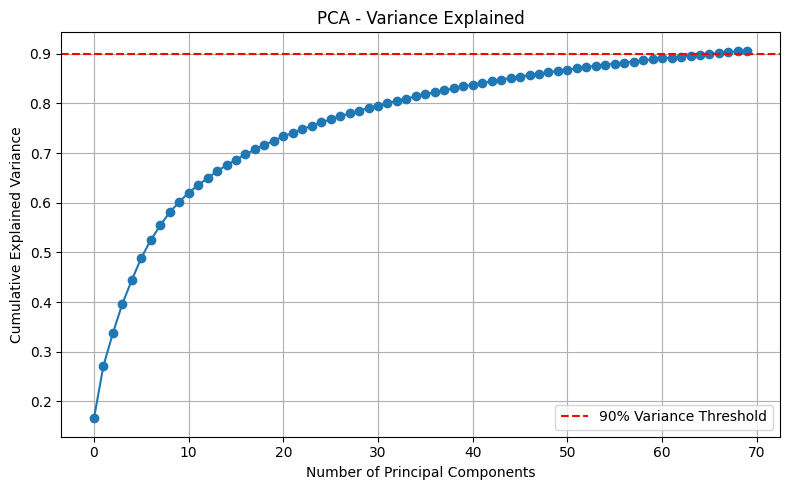

In [27]:
# Loading the embeddings of the model whose embeddings are to be analysed using PCA
embeddings, ids = load_embeddings(
    output_dir="paper_embeddings_output",
    embedding_filename="specter_trial.npy",
    paper_ids_filename="specter_trial.txt"
)

explained_variance = perform_pca_and_plot(
    embeddings=embeddings,
    n_components=70,
    variance_threshold=0.90
)


**BioBERT**

In [29]:
embeddings, paper_ids = generate_paper_embeddings(
    df=df,
    model_name="dmis-lab/biobert-v1.1",
    max_sequence_length=512,
    overlap_tokens=50,
    batch_size=16,
    output_dir="paper_embeddings_output",
    embedding_filename="biobert_trial.npy",
    paper_ids_filename="biobert_trial.txt"
)



Using device: cuda
Loading model: dmis-lab/biobert-v1.1


pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]


Processing 9343 papers...


Embedding papers:   0%|          | 0/9343 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (3146 > 512). Running this sequence through the model will result in indexing errors


Error processing PMC11197899 at /data/ftxmls/2024/PMC11197899.xml: Error reading file '/data/ftxmls/2024/PMC11197899.xml': failed to load "/data/ftxmls/2024/PMC11197899.xml": No such file or directory
Error processing PMC11095573 at /data/ftxmls/2024/PMC11095573.xml: Error reading file '/data/ftxmls/2024/PMC11095573.xml': failed to load "/data/ftxmls/2024/PMC11095573.xml": No such file or directory
Error processing PMC11073879 at /data/ftxmls/2024/PMC11073879.xml: Error reading file '/data/ftxmls/2024/PMC11073879.xml': failed to load "/data/ftxmls/2024/PMC11073879.xml": No such file or directory
Error processing PMC11286119 at /data/ftxmls/2024/PMC11286119.xml: Error reading file '/data/ftxmls/2024/PMC11286119.xml': failed to load "/data/ftxmls/2024/PMC11286119.xml": No such file or directory


model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Error processing PMC11590232 at /data/ftxmls/2024/PMC11590232.xml: Error reading file '/data/ftxmls/2024/PMC11590232.xml': failed to load "/data/ftxmls/2024/PMC11590232.xml": No such file or directory
Error processing PMC11310725 at /data/ftxmls/2024/PMC11310725.xml: Error reading file '/data/ftxmls/2024/PMC11310725.xml': failed to load "/data/ftxmls/2024/PMC11310725.xml": No such file or directory
Error processing PMC11286019 at /data/ftxmls/2024/PMC11286019.xml: Error reading file '/data/ftxmls/2024/PMC11286019.xml': failed to load "/data/ftxmls/2024/PMC11286019.xml": No such file or directory
Error processing PMC11444322 at /data/ftxmls/2024/PMC11444322.xml: Error reading file '/data/ftxmls/2024/PMC11444322.xml': failed to load "/data/ftxmls/2024/PMC11444322.xml": No such file or directory
Error processing PMC11412453 at /data/ftxmls/2024/PMC11412453.xml: Error reading file '/data/ftxmls/2024/PMC11412453.xml': failed to load "/data/ftxmls/2024/PMC11412453.xml": No such file or direc

✅ Loaded 7056 embeddings from 'paper_embeddings_output' with shape: (7056, 768)
Running PCA with 70 components on embeddings of shape (7056, 768)...


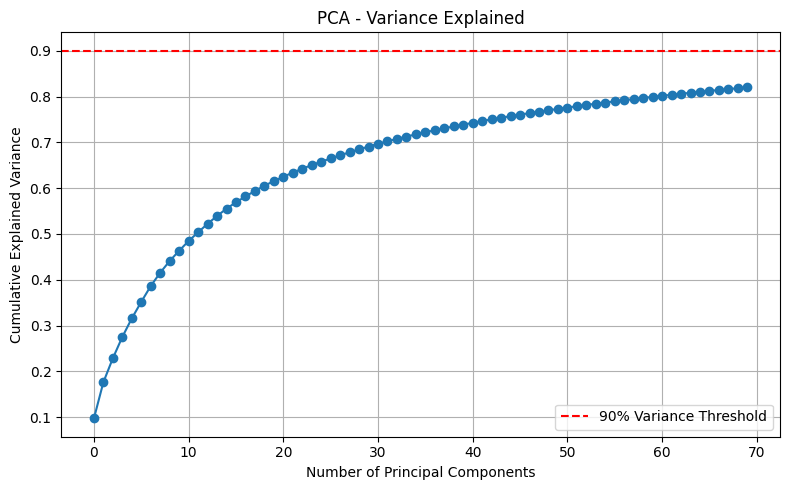

In [30]:
# Loading the embeddings of the model whose embeddings are to be analysed using PCA
embeddings, ids = load_embeddings(
    output_dir="paper_embeddings_output",
    embedding_filename="biobert_trial.npy",
    paper_ids_filename="biobert_trial.txt"
)

explained_variance = perform_pca_and_plot(
    embeddings=embeddings,
    n_components=70,
    variance_threshold=0.90
)


**allenai/scibert**

In [31]:
embeddings, paper_ids = generate_paper_embeddings(
    df=df,
    model_name="allenai/scibert_scivocab_uncased",
    max_sequence_length=512,
    overlap_tokens=50,
    batch_size=16,
    output_dir="paper_embeddings_output",
    embedding_filename="scibert_trial.npy",
    paper_ids_filename="scibert_trial.txt"
)



Using device: cuda
Loading model: allenai/scibert_scivocab_uncased


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]


Processing 9343 papers...


Embedding papers:   0%|          | 0/9343 [00:00<?, ?it/s]

Error processing PMC11197899 at /data/ftxmls/2024/PMC11197899.xml: Error reading file '/data/ftxmls/2024/PMC11197899.xml': failed to load "/data/ftxmls/2024/PMC11197899.xml": No such file or directory
Error processing PMC11095573 at /data/ftxmls/2024/PMC11095573.xml: Error reading file '/data/ftxmls/2024/PMC11095573.xml': failed to load "/data/ftxmls/2024/PMC11095573.xml": No such file or directory
Error processing PMC11073879 at /data/ftxmls/2024/PMC11073879.xml: Error reading file '/data/ftxmls/2024/PMC11073879.xml': failed to load "/data/ftxmls/2024/PMC11073879.xml": No such file or directory
Error processing PMC11286119 at /data/ftxmls/2024/PMC11286119.xml: Error reading file '/data/ftxmls/2024/PMC11286119.xml': failed to load "/data/ftxmls/2024/PMC11286119.xml": No such file or directory


model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Error processing PMC11590232 at /data/ftxmls/2024/PMC11590232.xml: Error reading file '/data/ftxmls/2024/PMC11590232.xml': failed to load "/data/ftxmls/2024/PMC11590232.xml": No such file or directory
Error processing PMC11310725 at /data/ftxmls/2024/PMC11310725.xml: Error reading file '/data/ftxmls/2024/PMC11310725.xml': failed to load "/data/ftxmls/2024/PMC11310725.xml": No such file or directory
Error processing PMC11286019 at /data/ftxmls/2024/PMC11286019.xml: Error reading file '/data/ftxmls/2024/PMC11286019.xml': failed to load "/data/ftxmls/2024/PMC11286019.xml": No such file or directory
Error processing PMC11444322 at /data/ftxmls/2024/PMC11444322.xml: Error reading file '/data/ftxmls/2024/PMC11444322.xml': failed to load "/data/ftxmls/2024/PMC11444322.xml": No such file or directory
Error processing PMC11412453 at /data/ftxmls/2024/PMC11412453.xml: Error reading file '/data/ftxmls/2024/PMC11412453.xml': failed to load "/data/ftxmls/2024/PMC11412453.xml": No such file or direc

✅ Loaded 7056 embeddings from 'paper_embeddings_output' with shape: (7056, 768)
Running PCA with 70 components on embeddings of shape (7056, 768)...


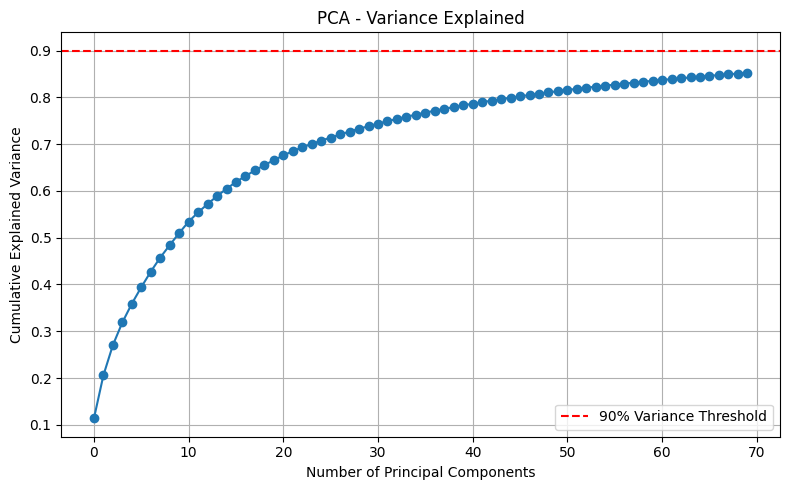

In [32]:
# Loading the embeddings of the model whose embeddings are to be analysed using PCA
embeddings, ids = load_embeddings(
    output_dir="paper_embeddings_output",
    embedding_filename="scibert_trial.npy",
    paper_ids_filename="scibert_trial.txt"
)

explained_variance = perform_pca_and_plot(
    embeddings=embeddings,
    n_components=70,
    variance_threshold=0.90
)


**microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext**

In [33]:
embeddings, paper_ids = generate_paper_embeddings(
    df=df,
    model_name="microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext",
    max_sequence_length=512,
    overlap_tokens=50,
    batch_size=16,
    output_dir="paper_embeddings_output",
    embedding_filename="microsoft_trial.npy",
    paper_ids_filename="microsoft_trial.txt"
)



Using device: cuda
Loading model: microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]


Processing 9343 papers...


Embedding papers:   0%|          | 0/9343 [00:00<?, ?it/s]

Error processing PMC11197899 at /data/ftxmls/2024/PMC11197899.xml: Error reading file '/data/ftxmls/2024/PMC11197899.xml': failed to load "/data/ftxmls/2024/PMC11197899.xml": No such file or directory
Error processing PMC11095573 at /data/ftxmls/2024/PMC11095573.xml: Error reading file '/data/ftxmls/2024/PMC11095573.xml': failed to load "/data/ftxmls/2024/PMC11095573.xml": No such file or directory
Error processing PMC11073879 at /data/ftxmls/2024/PMC11073879.xml: Error reading file '/data/ftxmls/2024/PMC11073879.xml': failed to load "/data/ftxmls/2024/PMC11073879.xml": No such file or directory
Error processing PMC11286119 at /data/ftxmls/2024/PMC11286119.xml: Error reading file '/data/ftxmls/2024/PMC11286119.xml': failed to load "/data/ftxmls/2024/PMC11286119.xml": No such file or directory


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Error processing PMC11590232 at /data/ftxmls/2024/PMC11590232.xml: Error reading file '/data/ftxmls/2024/PMC11590232.xml': failed to load "/data/ftxmls/2024/PMC11590232.xml": No such file or directory
Error processing PMC11310725 at /data/ftxmls/2024/PMC11310725.xml: Error reading file '/data/ftxmls/2024/PMC11310725.xml': failed to load "/data/ftxmls/2024/PMC11310725.xml": No such file or directory
Error processing PMC11286019 at /data/ftxmls/2024/PMC11286019.xml: Error reading file '/data/ftxmls/2024/PMC11286019.xml': failed to load "/data/ftxmls/2024/PMC11286019.xml": No such file or directory
Error processing PMC11444322 at /data/ftxmls/2024/PMC11444322.xml: Error reading file '/data/ftxmls/2024/PMC11444322.xml': failed to load "/data/ftxmls/2024/PMC11444322.xml": No such file or directory
Error processing PMC11412453 at /data/ftxmls/2024/PMC11412453.xml: Error reading file '/data/ftxmls/2024/PMC11412453.xml': failed to load "/data/ftxmls/2024/PMC11412453.xml": No such file or direc

✅ Loaded 7056 embeddings from 'paper_embeddings_output' with shape: (7056, 768)
Running PCA with 70 components on embeddings of shape (7056, 768)...


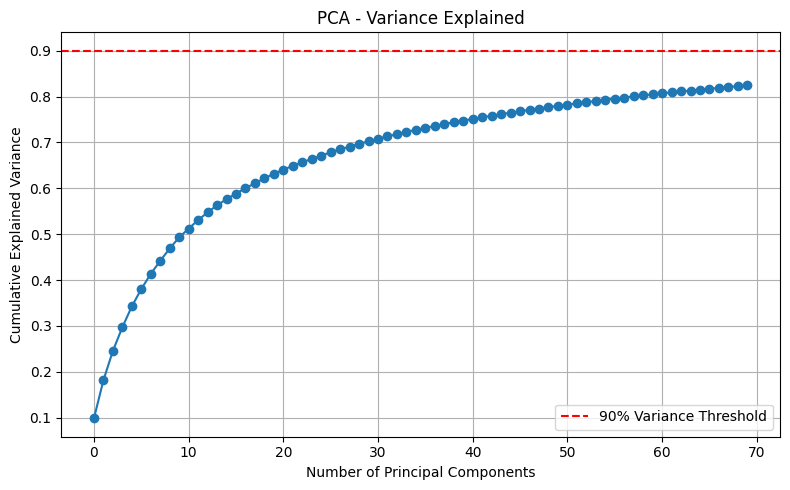

In [38]:
# Loading the embeddings of the model whose embeddings are to be analysed using PCA
embeddings, ids = load_embeddings(
    output_dir="paper_embeddings_output",
    embedding_filename="microsoft_trial.npy",
    paper_ids_filename="microsoft_trial.txt"
)

explained_variance = perform_pca_and_plot(
    embeddings=embeddings,
    n_components=70,
    variance_threshold=0.90
)


**microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext**

In [35]:
embeddings, paper_ids = generate_paper_embeddings(
    df=df,
    model_name="microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
    max_sequence_length=512,
    overlap_tokens=50,
    batch_size=16,
    output_dir="paper_embeddings_output",
    embedding_filename="pubmedbert_trial.npy",
    paper_ids_filename="pubmedbert_trial.txt"
)



Using device: cuda
Loading model: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]


Processing 9343 papers...


Embedding papers:   0%|          | 0/9343 [00:00<?, ?it/s]

Error processing PMC11197899 at /data/ftxmls/2024/PMC11197899.xml: Error reading file '/data/ftxmls/2024/PMC11197899.xml': failed to load "/data/ftxmls/2024/PMC11197899.xml": No such file or directory
Error processing PMC11095573 at /data/ftxmls/2024/PMC11095573.xml: Error reading file '/data/ftxmls/2024/PMC11095573.xml': failed to load "/data/ftxmls/2024/PMC11095573.xml": No such file or directory
Error processing PMC11073879 at /data/ftxmls/2024/PMC11073879.xml: Error reading file '/data/ftxmls/2024/PMC11073879.xml': failed to load "/data/ftxmls/2024/PMC11073879.xml": No such file or directory
Error processing PMC11286119 at /data/ftxmls/2024/PMC11286119.xml: Error reading file '/data/ftxmls/2024/PMC11286119.xml': failed to load "/data/ftxmls/2024/PMC11286119.xml": No such file or directory
Error processing PMC11590232 at /data/ftxmls/2024/PMC11590232.xml: Error reading file '/data/ftxmls/2024/PMC11590232.xml': failed to load "/data/ftxmls/2024/PMC11590232.xml": No such file or direc

In [36]:
# Loading the embeddings of the model whose embeddings are to be analysed using PCA
embeddings, ids = load_embeddings(
    output_dir="paper_embeddings_output",
    embedding_filename="pubmedbert_trial.npy",
    paper_ids_filename="pubmedbert_trial.txt"
)

explained_variance = perform_pca_and_plot(
    embeddings=embeddings,
    n_components=70,
    variance_threshold=0.90
)


✅ Loaded 7056 embeddings from 'paper_embeddings_output' with shape: (7056, 768)
Running PCA with 70 components on embeddings of shape (7056, 768)...


**microsoft/BioGPT**

In [54]:
!pip install sacremoses protobuf

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 KB 8.3 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 KB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 KB 26.1 MB/s eta 0:00:00


In [55]:
embeddings, paper_ids = generate_paper_embeddings(
    df=df,
    model_name="microsoft/BioGPT",
    max_sequence_length=1024,
    overlap_tokens=50,
    batch_size=16,
    output_dir="paper_embeddings_output",
    embedding_filename="biogpt_trial.npy",
    paper_ids_filename="biogpt_trial.txt"
)



Using device: cuda
Loading model: microsoft/BioGPT


pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]


Processing 9343 papers...


Embedding papers:   0%|          | 0/9343 [00:00<?, ?it/s]

Error processing PMC11197899 at /data/ftxmls/2024/PMC11197899.xml: Error reading file '/data/ftxmls/2024/PMC11197899.xml': failed to load "/data/ftxmls/2024/PMC11197899.xml": No such file or directory
Error processing PMC11095573 at /data/ftxmls/2024/PMC11095573.xml: Error reading file '/data/ftxmls/2024/PMC11095573.xml': failed to load "/data/ftxmls/2024/PMC11095573.xml": No such file or directory
Error processing PMC11073879 at /data/ftxmls/2024/PMC11073879.xml: Error reading file '/data/ftxmls/2024/PMC11073879.xml': failed to load "/data/ftxmls/2024/PMC11073879.xml": No such file or directory
Error processing PMC11286119 at /data/ftxmls/2024/PMC11286119.xml: Error reading file '/data/ftxmls/2024/PMC11286119.xml': failed to load "/data/ftxmls/2024/PMC11286119.xml": No such file or directory


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Error processing PMC11590232 at /data/ftxmls/2024/PMC11590232.xml: Error reading file '/data/ftxmls/2024/PMC11590232.xml': failed to load "/data/ftxmls/2024/PMC11590232.xml": No such file or directory
Error processing PMC11310725 at /data/ftxmls/2024/PMC11310725.xml: Error reading file '/data/ftxmls/2024/PMC11310725.xml': failed to load "/data/ftxmls/2024/PMC11310725.xml": No such file or directory
Error processing PMC11286019 at /data/ftxmls/2024/PMC11286019.xml: Error reading file '/data/ftxmls/2024/PMC11286019.xml': failed to load "/data/ftxmls/2024/PMC11286019.xml": No such file or directory
Error processing PMC11444322 at /data/ftxmls/2024/PMC11444322.xml: Error reading file '/data/ftxmls/2024/PMC11444322.xml': failed to load "/data/ftxmls/2024/PMC11444322.xml": No such file or directory
Error processing PMC11412453 at /data/ftxmls/2024/PMC11412453.xml: Error reading file '/data/ftxmls/2024/PMC11412453.xml': failed to load "/data/ftxmls/2024/PMC11412453.xml": No such file or direc

In [56]:
# Loading the embeddings of the model whose embeddings are to be analysed using PCA
embeddings, ids = load_embeddings(
    output_dir="paper_embeddings_output",
    embedding_filename="biogpt_trial.npy",
    paper_ids_filename="biogpt_trial.txt"
)

explained_variance = perform_pca_and_plot(
    embeddings=embeddings,
    n_components=70,
    variance_threshold=0.90
)


✅ Loaded 7056 embeddings from 'paper_embeddings_output' with shape: (7056, 1024)
Running PCA with 70 components on embeddings of shape (7056, 1024)...


**MedEmbed-small-v0.1**

In [61]:
embeddings, paper_ids = generate_paper_embeddings(
    df=df,
    model_name="abhinand/MedEmbed-small-v0.1",
    max_sequence_length=512,
    overlap_tokens=50,
    batch_size=16,
    output_dir="paper_embeddings_output",
    embedding_filename="medembed_trial.npy",
    paper_ids_filename="medembed_trial.txt"
)



Using device: cuda
Loading model: abhinand/MedEmbed-small-v0.1


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]


Processing 9343 papers...


Embedding papers:   0%|          | 0/9343 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (3001 > 512). Running this sequence through the model will result in indexing errors


Error processing PMC11197899 at /data/ftxmls/2024/PMC11197899.xml: Error reading file '/data/ftxmls/2024/PMC11197899.xml': failed to load "/data/ftxmls/2024/PMC11197899.xml": No such file or directory
Error processing PMC11095573 at /data/ftxmls/2024/PMC11095573.xml: Error reading file '/data/ftxmls/2024/PMC11095573.xml': failed to load "/data/ftxmls/2024/PMC11095573.xml": No such file or directory
Error processing PMC11073879 at /data/ftxmls/2024/PMC11073879.xml: Error reading file '/data/ftxmls/2024/PMC11073879.xml': failed to load "/data/ftxmls/2024/PMC11073879.xml": No such file or directory
Error processing PMC11286119 at /data/ftxmls/2024/PMC11286119.xml: Error reading file '/data/ftxmls/2024/PMC11286119.xml': failed to load "/data/ftxmls/2024/PMC11286119.xml": No such file or directory
Error processing PMC11590232 at /data/ftxmls/2024/PMC11590232.xml: Error reading file '/data/ftxmls/2024/PMC11590232.xml': failed to load "/data/ftxmls/2024/PMC11590232.xml": No such file or direc

✅ Loaded 7056 embeddings from 'paper_embeddings_output' with shape: (7056, 384)
Running PCA with 70 components on embeddings of shape (7056, 384)...


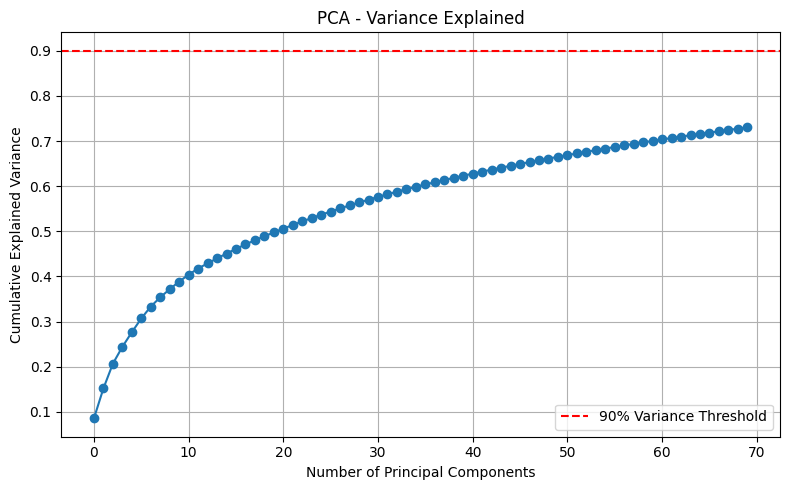

In [62]:
# Loading the embeddings of the model whose embeddings are to be analysed using PCA
embeddings, ids = load_embeddings(
    output_dir="paper_embeddings_output",
    embedding_filename="medembed_trial.npy",
    paper_ids_filename="medembed_trial.txt"
)

explained_variance = perform_pca_and_plot(
    embeddings=embeddings,
    n_components=70,
    variance_threshold=0.90
)


**Biomistral**

In [51]:
process_dataframe_for_biomistral_embeddings(
    df=df,
    model_name="BioMistral/BioMistral-7B",
    output_dir="paper_embeddings_output",
    max_tokens=512,
    embedding_filename="biomistral_trial.npy",
    paper_ids_filename="biomistral_trial.txt"
)



Loading model: BioMistral/BioMistral-7B


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.5G [00:00<?, ?B/s]


 Processing 9343 papers...



Embedding Papers:   0%|          | 0/9343 [00:00<?, ?it/s]

Error processing PMC11197899: Error reading file '/data/ftxmls/2024/PMC11197899.xml': failed to load "/data/ftxmls/2024/PMC11197899.xml": No such file or directory
Error processing PMC11095573: Error reading file '/data/ftxmls/2024/PMC11095573.xml': failed to load "/data/ftxmls/2024/PMC11095573.xml": No such file or directory
Error processing PMC11073879: Error reading file '/data/ftxmls/2024/PMC11073879.xml': failed to load "/data/ftxmls/2024/PMC11073879.xml": No such file or directory
Error processing PMC11286119: Error reading file '/data/ftxmls/2024/PMC11286119.xml': failed to load "/data/ftxmls/2024/PMC11286119.xml": No such file or directory
Error processing PMC11590232: Error reading file '/data/ftxmls/2024/PMC11590232.xml': failed to load "/data/ftxmls/2024/PMC11590232.xml": No such file or directory
Error processing PMC11310725: Error reading file '/data/ftxmls/2024/PMC11310725.xml': failed to load "/data/ftxmls/2024/PMC11310725.xml": No such file or directory
Error processing

In [52]:
# Loading the embeddings of the model whose embeddings are to be analysed using PCA
embeddings, ids = load_embeddings(
    output_dir="paper_embeddings_output",
    embedding_filename="biomistral_trial.npy",
    paper_ids_filename="biomistral_trial.txt"
)

explained_variance = perform_pca_and_plot(
    embeddings=embeddings,
    n_components=70,
    variance_threshold=0.90
)


✅ Loaded 7067 embeddings from 'paper_embeddings_output' with shape: (7067, 4096)
Running PCA with 70 components on embeddings of shape (7067, 4096)...


**OpenAI**

In [57]:
!pip install openai

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.1/755.1 KB 15.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.5/352.5 KB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 KB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 59.2 MB/s eta 0:00:0000:01


In [58]:
from llmfuncs import LLMHelper

In [59]:
llm_helper=LLMHelper()

process_dataframe_for_openai_embeddings(
    df=df,
    llm_helper=llm_helper,
    model_name="text-embedding-3-small",
    output_dir="paper_embeddings_output",
    max_tokens=400,
    embedding_filename="openai_trial.npy",
    paper_ids_filename="openai_trial.txt"
)



Processing 9343 papers using OpenAI model `text-embedding-3-small`...


Embedding Papers:   0%|          | 0/9343 [00:00<?, ?it/s]

Error processing PMC11197899: Error reading file '/data/ftxmls/2024/PMC11197899.xml': failed to load "/data/ftxmls/2024/PMC11197899.xml": No such file or directory
Error processing PMC11095573: Error reading file '/data/ftxmls/2024/PMC11095573.xml': failed to load "/data/ftxmls/2024/PMC11095573.xml": No such file or directory
Error processing PMC11073879: Error reading file '/data/ftxmls/2024/PMC11073879.xml': failed to load "/data/ftxmls/2024/PMC11073879.xml": No such file or directory
Error processing PMC11286119: Error reading file '/data/ftxmls/2024/PMC11286119.xml': failed to load "/data/ftxmls/2024/PMC11286119.xml": No such file or directory
Error processing PMC11590232: Error reading file '/data/ftxmls/2024/PMC11590232.xml': failed to load "/data/ftxmls/2024/PMC11590232.xml": No such file or directory
Error processing PMC11310725: Error reading file '/data/ftxmls/2024/PMC11310725.xml': failed to load "/data/ftxmls/2024/PMC11310725.xml": No such file or directory
Error processing

✅ Loaded 7023 embeddings from 'paper_embeddings_output' with shape: (7023, 4096)
Running PCA with 70 components on embeddings of shape (7023, 4096)...


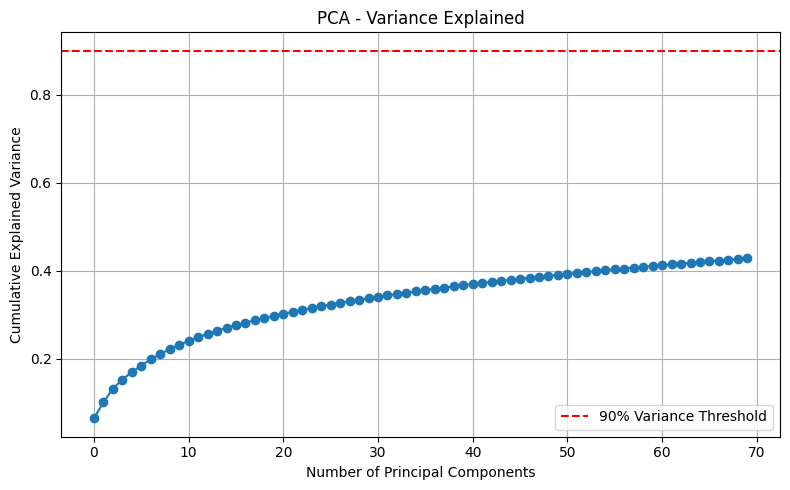

In [60]:
# Loading the embeddings of the model whose embeddings are to be analysed using PCA
embeddings, ids = load_embeddings(
    output_dir="paper_embeddings_output",
    embedding_filename="openai_trial.npy",
    paper_ids_filename="openai_trial.txt"
)

explained_variance = perform_pca_and_plot(
    embeddings=embeddings,
    n_components=70,
    variance_threshold=0.90
)
